## Phase 1: Loading packages and importing datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import random
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers
from keras.layers import Activation, LSTM, Dense, SimpleRNN, Dropout, GRU
from keras.optimizers import RMSprop
from statsmodels.tsa.stattools import adfuller


In [3]:
np.random.seed(42)
random.seed(42)

In [4]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [5]:
# import google stocks data setting 2011-2021 training set and 2021-2022 testing set

stock = 'GOOGL'

start = pd.to_datetime(['2011-11-1']).astype(int)[0]//10**9
end = pd.to_datetime(['2021-10-31']).astype(int)[0]//10**9
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
train_df = pd.read_csv(url)

start = pd.to_datetime(['2021-11-1']).astype(int)[0]//10**9
end = pd.to_datetime(['2022-10-31']).astype(int)[0]//10**9
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
test_df = pd.read_csv(url)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  # This is added back by InteractiveShellApp.init_path()


In [6]:
train_df.head

<bound method NDFrame.head of             Date        Open        High         Low       Close   Adj Close  \
0     2011-11-01   14.517017   14.652402   14.433183   14.480731   14.480731   
1     2011-11-02   14.637137   14.713714   14.526527   14.635135   14.635135   
2     2011-11-03   14.689690   14.952452   14.607608   14.952452   14.952452   
3     2011-11-04   14.852352   15.008509   14.825576   14.918418   14.918418   
4     2011-11-07   14.847848   15.234735   14.820571   15.223473   15.223473   
...          ...         ...         ...         ...         ...         ...   
2511  2021-10-25  137.550003  138.000000  135.423996  137.447006  137.447006   
2512  2021-10-26  139.263504  140.082993  138.304504  139.308502  139.308502   
2513  2021-10-27  139.404999  148.649994  139.404999  146.217499  146.217499   
2514  2021-10-28  147.134506  147.158005  144.626999  145.848999  145.848999   
2515  2021-10-29  145.078003  148.242004  144.649506  148.046005  148.046005   

         

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0c868c390>,
      dtype=object)

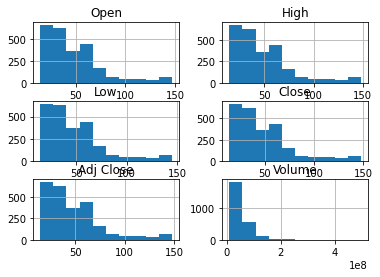

In [97]:
train_df.hist()

## Phase 2: Preliminary modeling

### Section 1: Min-max Scaler

In [ ]:
# first round of tests will use minmax scaler
# fit and transform training dataset
scaler =  MinMaxScaler()
scaled_df = scaler.fit_transform(train_df['Adj Close'].values.reshape(-1,1))

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
# fit and transform test dataset
#sc =  StandardScaler()
#scaled_test_df = sc.fit_transform(test_df['Adj Close'].values.reshape(-1,1))
#scaled_test_df = sc.transform(scaled_test_df)

In [ ]:
# Concatenate training and test datasets to create a total dataset
# which will shape the inputs and thus 

total_df = pd.concat((train_df['Adj Close'], test_df['Adj Close']), axis=0) 
inputs = total_df[len(train_df) - len(total_df) - days:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [ ]:
X_test = []
for i in range(days, len(inputs)):
  X_test.append(inputs[i-days:i,0])

In [ ]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [ ]:
y_test = test_df['Adj Close'].values
real_prices = test_df['Adj Close'].values

#### Baseline RNN model

##### First RNN - sigmoid, adam

In [ ]:
#start with a basic 
model= Sequential()
model.add(SimpleRNN(2, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.33, epochs=100, batch_size=32, callbacks = [callback])

Epoch 1/100
52/52 [==============================] - 2s 17ms/step - loss: 1092.9344 - mean_squared_error: 1092.9344 - val_loss: 5685.5825 - val_mean_squared_error: 5685.5825
Epoch 2/100
52/52 [==============================] - 1s 14ms/step - loss: 1081.4779 - mean_squared_error: 1081.4779 - val_loss: 5671.7188 - val_mean_squared_error: 5671.7188
Epoch 3/100
52/52 [==============================] - 1s 12ms/step - loss: 1077.7731 - mean_squared_error: 1077.7731 - val_loss: 5665.5908 - val_mean_squared_error: 5665.5908
Epoch 4/100
52/52 [==============================] - 1s 13ms/step - loss: 1075.5414 - mean_squared_error: 1075.5414 - val_loss: 5661.2095 - val_mean_squared_error: 5661.2095
Epoch 5/100
52/52 [==============================] - 1s 13ms/step - loss: 1073.8900 - mean_squared_error: 1073.8900 - val_loss: 5657.9409 - val_mean_squared_error: 5657.9409
Epoch 6/100
52/52 [==============================] - 1s 13ms/step - loss: 1072.6309 - mean_squared_error: 1072.6309 - val_loss: 56

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


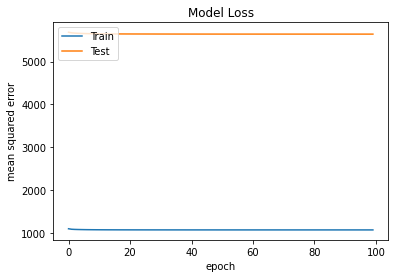

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_1_pred = model.predict(X_test)
model_1_pred = scaler.inverse_transform(model_1_pred)

8/8 [==============================] - 0s 4ms/step


In [ ]:
r2_score(y_test, model_1_pred)

-2.0148438074823933

8/8 [==============================] - 0s 5ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses t

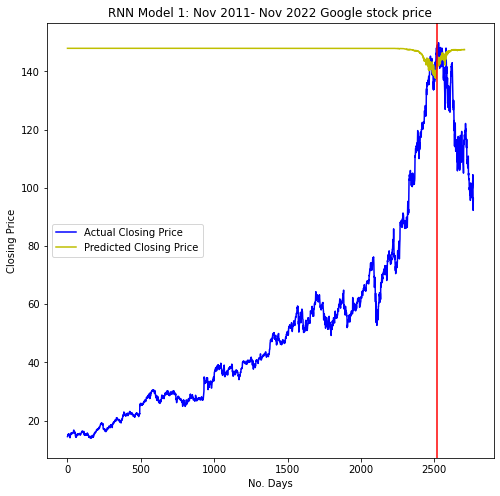

In [ ]:
train_pred = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
test_pred = model.predict(X_test)
total_data_pred = np.vstack([train_pred, model_1_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))
plt.title(f"RNN Model 1: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_pred.ravel(), color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

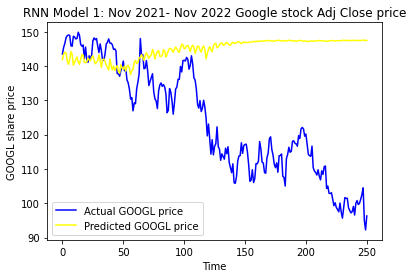

In [ ]:
plt.plot(y_test, color='blue', label = f"Actual {stock} price")
plt.plot(model_1_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"RNN Model 1: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Second RNN - sigmoid, SGD

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model= Sequential()
model.add(SimpleRNN(2, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='SGD',loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.33, epochs=100, batch_size=32, callbacks = [callback])

Epoch 1/100
52/52 [==============================] - 2s 17ms/step - loss: 0.0774 - mean_squared_error: 0.0774 - val_loss: 0.0631 - val_mean_squared_error: 0.0631
Epoch 2/100
52/52 [==============================] - 1s 12ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - val_loss: 0.0704 - val_mean_squared_error: 0.0704
Epoch 3/100
52/52 [==============================] - 1s 12ms/step - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0767 - val_mean_squared_error: 0.0767
Epoch 4/100
52/52 [==============================] - 1s 13ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0823 - val_mean_squared_error: 0.0823
Epoch 5/100
52/52 [==============================] - 1s 13ms/step - loss: 0.0272 - mean_squared_error: 0.0272 - val_loss: 0.0874 - val_mean_squared_error: 0.0874
Epoch 6/100
52/52 [==============================] - 1s 12ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0921 - val_mean_squared_error: 0.0921
Epoch 7/100
52/52 [=========

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


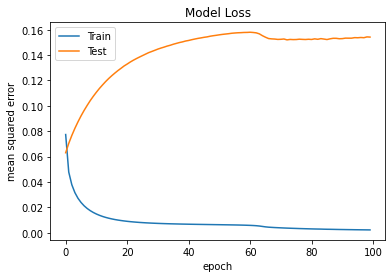

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_1_pred = model.predict(X_test)
model_1_pred = scaler.inverse_transform(model_1_pred)

8/8 [==============================] - 0s 4ms/step


In [ ]:
r2_score(y_test, model_1_pred)

-35.1671357969651

8/8 [==============================] - 0s 4ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses t

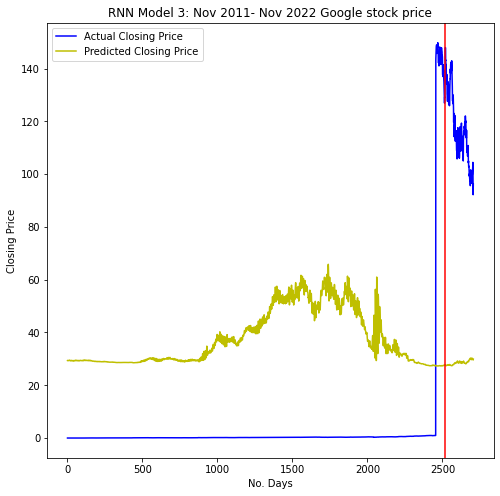

In [ ]:
train_pred = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
test_pred = model.predict(X_test)
total_data_pred = np.vstack([train_pred, model_1_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))
plt.title(f"RNN Model 3: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_pred.ravel(), color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

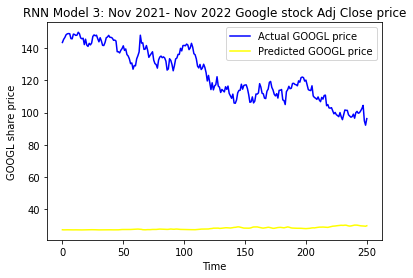

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_1_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"RNN Model 3: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Third RNN - relu, adam

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model= Sequential()
model.add(SimpleRNN(2, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation="relu"))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.33, epochs=100, batch_size=32, callbacks = [callback])

Epoch 1/100
52/52 [==============================] - 2s 18ms/step - loss: 0.1053 - mean_squared_error: 0.1053 - val_loss: 0.0423 - val_mean_squared_error: 0.0423
Epoch 2/100
52/52 [==============================] - 1s 12ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 3/100
52/52 [==============================] - 1s 13ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0404 - val_mean_squared_error: 0.0404
Epoch 4/100
52/52 [==============================] - 1s 13ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 5/100
52/52 [==============================] - 1s 17ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 6/100
52/52 [==============================] - 1s 23ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0522 - val_mean_squared_error: 0.0522
Epoch 7/100
52/52 [=========

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


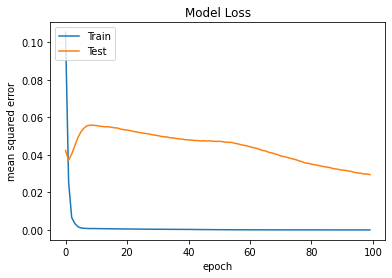

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
model_1_pred = model.predict(X_test)
model_1_pred = scaler.inverse_transform(model_1_pred)

8/8 [==============================] - 0s 4ms/step


In [ ]:
r2_score(y_test, model_1_pred)

-7.533226652472386

8/8 [==============================] - 0s 5ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses t

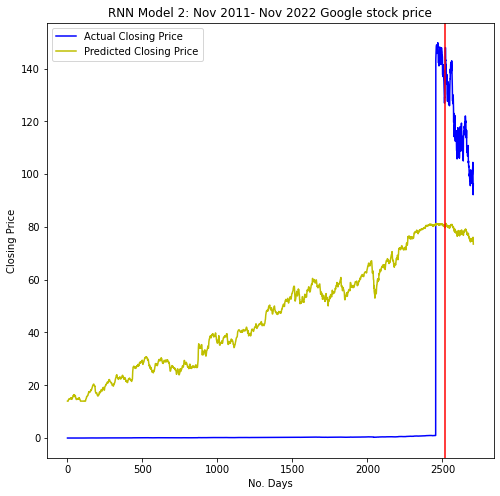

In [ ]:
train_pred = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
test_pred = model.predict(X_test)
total_data_pred = np.vstack([train_pred, model_1_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))
plt.title(f"RNN Model 2: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_pred.ravel(), color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

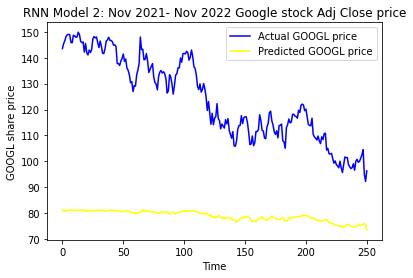

In [ ]:
plt.plot(y_test, color='blue', label = f"Actual {stock} price")
plt.plot(model_1_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"RNN Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Fourth RNN - relu, SGD

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model= Sequential()
model.add(SimpleRNN(2, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation="relu"))
model.compile(optimizer='SGD',loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.33, epochs=100, batch_size=32, callbacks = [callback])

Epoch 1/100
52/52 [==============================] - 2s 19ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.2764 - val_mean_squared_error: 0.2764
Epoch 2/100
52/52 [==============================] - 1s 14ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.2764 - val_mean_squared_error: 0.2764
Epoch 3/100
52/52 [==============================] - 1s 13ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.2764 - val_mean_squared_error: 0.2764
Epoch 4/100
52/52 [==============================] - 1s 13ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.2764 - val_mean_squared_error: 0.2764
Epoch 5/100
52/52 [==============================] - 1s 13ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.2764 - val_mean_squared_error: 0.2764
Epoch 6/100
52/52 [==============================] - 1s 12ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.2764 - val_mean_squared_error: 0.2764
Epoch 7/100
52/52 [=========

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


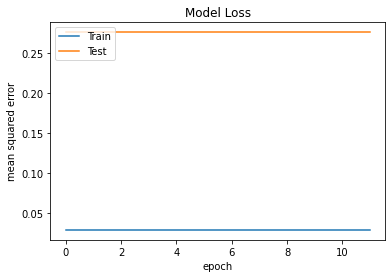

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_1_pred = model.predict(X_test)
model_1_pred = scaler.inverse_transform(model_1_pred)

8/8 [==============================] - 0s 4ms/step


In [ ]:
r2_score(y_test, model_1_pred)

-46.323659926677145

8/8 [==============================] - 0s 4ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses t

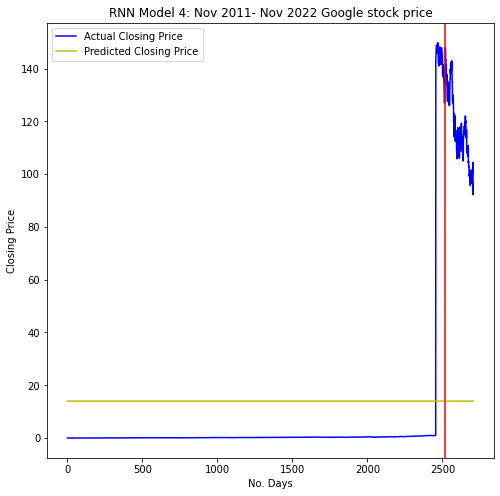

In [ ]:
train_pred = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
test_pred = model.predict(X_test)
total_data_pred = np.vstack([train_pred, model_1_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))
plt.title(f"RNN Model 4: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_pred.ravel(), color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

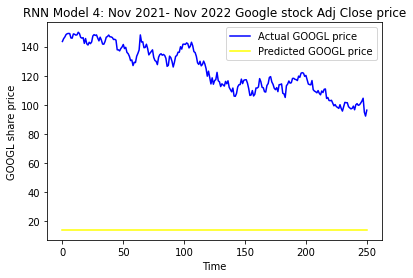

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_1_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"RNN Model 4: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50, activation = "sigmoid"))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_2.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 18s 193ms/step - loss: 0.2371 - mean_squared_error: 0.2371 - val_loss: 0.1286 - val_mean_squared_error: 0.1286
Epoch 2/50
52/52 [==============================] - 8s 146ms/step - loss: 0.0515 - mean_squared_error: 0.0515 - val_loss: 0.1427 - val_mean_squared_error: 0.1427
Epoch 3/50
52/52 [==============================] - 8s 147ms/step - loss: 0.0351 - mean_squared_error: 0.0351 - val_loss: 0.1016 - val_mean_squared_error: 0.1016
Epoch 4/50
52/52 [==============================] - 8s 145ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0852 - val_mean_squared_error: 0.0852
Epoch 5/50
52/52 [==============================] - 8s 145ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0915 - val_mean_squared_error: 0.0915
Epoch 6/50
52/52 [==============================] - 8s 145ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0844 - val_mean_squared_error: 0.0844
Epoch 7/50
52/52 [=========

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


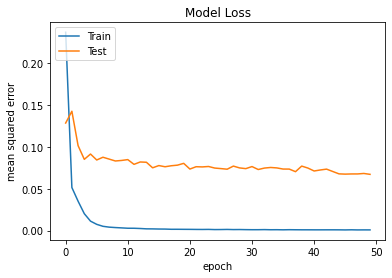

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_2_pred = model_2.predict(X_test)
model_2_pred = scaler.inverse_transform(model_2_pred)

8/8 [==============================] - 2s 35ms/step


In [ ]:
r2_score(y_test, model_2_pred)

-17.116772404171865

77/77 [==============================] - 3s 35ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

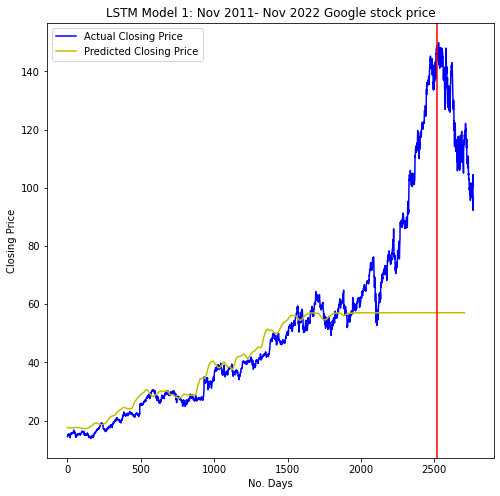

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_2.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_2_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM Model 1: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

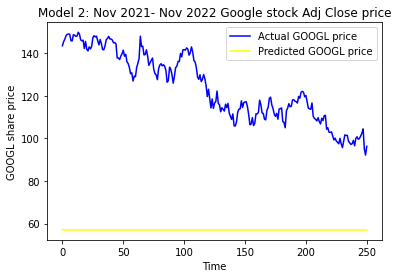

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_2_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Fifth RNN - tanh, adam

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model= Sequential()
model.add(SimpleRNN(2, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation="tanh"))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.33, epochs=100, batch_size=32, callbacks = [callback])

Epoch 1/100
52/52 [==============================] - 2s 18ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.2192 - val_mean_squared_error: 0.2192
Epoch 2/100
52/52 [==============================] - 1s 12ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.1674 - val_mean_squared_error: 0.1674
Epoch 3/100
52/52 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.1294 - val_mean_squared_error: 0.1294
Epoch 4/100
52/52 [==============================] - 1s 12ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.1032 - val_mean_squared_error: 0.1032
Epoch 5/100
52/52 [==============================] - 1s 12ms/step - loss: 9.6945e-04 - mean_squared_error: 9.6945e-04 - val_loss: 0.0855 - val_mean_squared_error: 0.0855
Epoch 6/100
52/52 [==============================] - 1s 12ms/step - loss: 5.5172e-04 - mean_squared_error: 5.5172e-04 - val_loss: 0.0757 - val_mean_squared_error: 0.0757
Epoch 7/100


dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


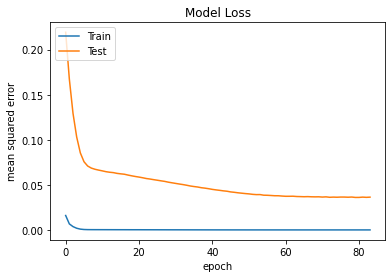

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
model_1_pred = model.predict(X_test)
model_1_pred = scaler.inverse_transform(model_1_pred)

8/8 [==============================] - 0s 4ms/step


In [ ]:
r2_score(y_test, model_1_pred)

-9.233596026236588

8/8 [==============================] - 0s 4ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses t

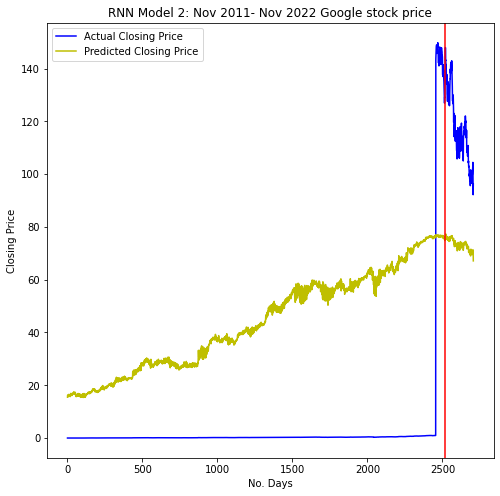

In [ ]:
train_pred = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
test_pred = model.predict(X_test)
total_data_pred = np.vstack([train_pred, model_1_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))
plt.title(f"RNN Model 2: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_pred.ravel(), color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

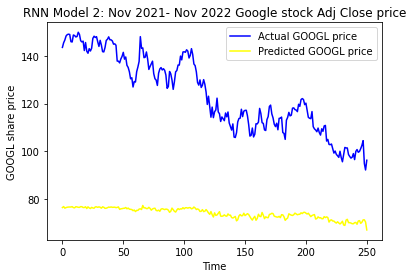

In [ ]:
plt.plot(y_test, color='blue', label = f"Actual {stock} price")
plt.plot(model_1_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"RNN Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Sixth RNN - tanh, SGD

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model= Sequential()
model.add(SimpleRNN(2, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation="tanh"))
model.compile(optimizer='SGD',loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.33, epochs=100, batch_size=32, callbacks = [callback])

Epoch 1/100
52/52 [==============================] - 3s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0986 - val_mean_squared_error: 0.0986
Epoch 2/100
52/52 [==============================] - 1s 14ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0962 - val_mean_squared_error: 0.0962
Epoch 3/100
52/52 [==============================] - 1s 13ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0915 - val_mean_squared_error: 0.0915
Epoch 4/100
52/52 [==============================] - 1s 13ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0890 - val_mean_squared_error: 0.0890
Epoch 5/100
52/52 [==============================] - 1s 12ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0880 - val_mean_squared_error: 0.0880
Epoch 6/100
52/52 [==============================] - 1s 12ms/step - loss: 9.9292e-04 - mean_squared_error: 9.9292e-04 - val_loss: 0.0853 - val_mean_squared_error: 0.0853
Epoch 7/100
52/52 [=

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


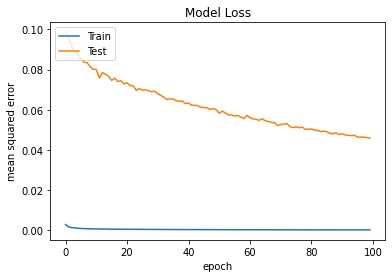

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_1_pred = model.predict(X_test)
model_1_pred = scaler.inverse_transform(model_1_pred)

8/8 [==============================] - 0s 4ms/step


In [ ]:
r2_score(y_test, model_1_pred)

-11.498753376197278

8/8 [==============================] - 0s 5ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses t

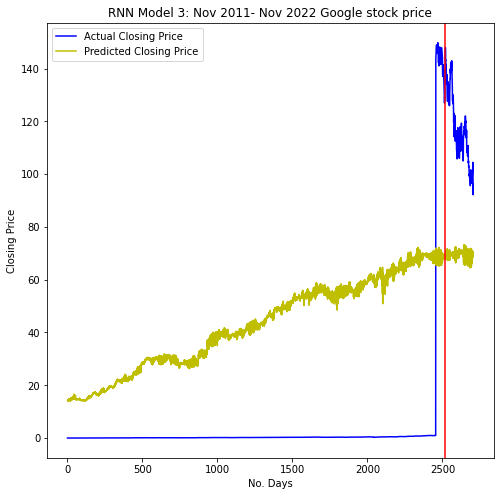

In [ ]:
train_pred = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
test_pred = model.predict(X_test)
total_data_pred = np.vstack([train_pred, model_1_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))
plt.title(f"RNN Model 3: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_pred.ravel(), color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

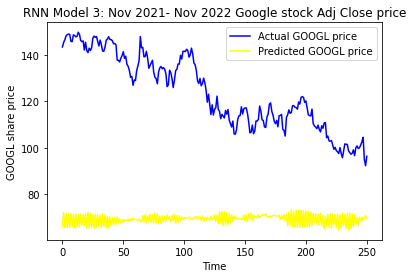

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_1_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"RNN Model 3: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

#### Long Short-Term Memory (LSTM) models and experimentation

##### First LSTM - Sigmoid, adam

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50, activation = "sigmoid"))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_2.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 19s 195ms/step - loss: 0.1049 - mean_squared_error: 0.1049 - val_loss: 0.1422 - val_mean_squared_error: 0.1422
Epoch 2/50
52/52 [==============================] - 8s 147ms/step - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0637 - val_mean_squared_error: 0.0637
Epoch 3/50
52/52 [==============================] - 8s 155ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0748 - val_mean_squared_error: 0.0748
Epoch 4/50
52/52 [==============================] - 10s 199ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0761 - val_mean_squared_error: 0.0761
Epoch 5/50
52/52 [==============================] - 10s 197ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0751 - val_mean_squared_error: 0.0751
Epoch 6/50
52/52 [==============================] - 10s 201ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0771 - val_mean_squared_error: 0.0771
Epoch 7/50
52/52 [======

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


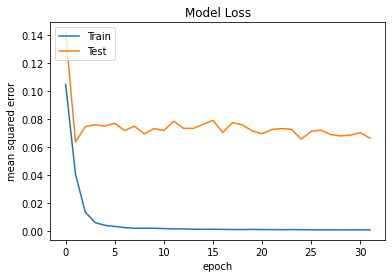

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_2_pred = model_2.predict(X_test)
model_2_pred = scaler.inverse_transform(model_2_pred)

8/8 [==============================] - 2s 35ms/step


In [ ]:
r2_score(y_test, model_2_pred)

-18.082132510475645

77/77 [==============================] - 3s 35ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

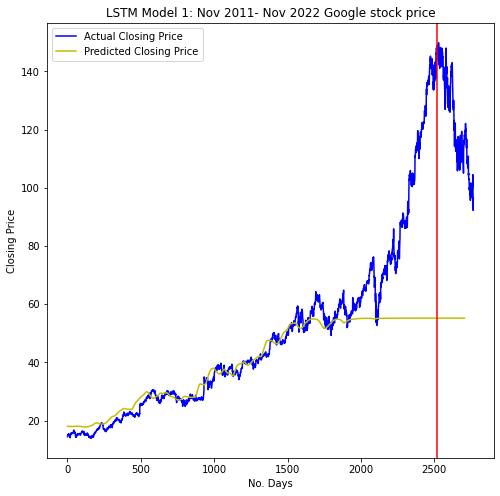

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_2.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_2_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM Model 1: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

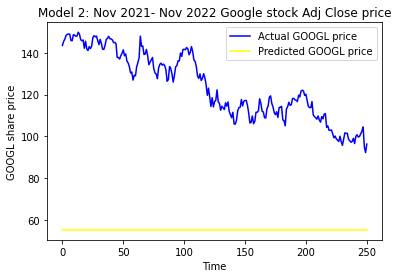

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_2_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Second LSTM - Sigmoid, SGD

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50, activation = "sigmoid"))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))
model_2.compile(optimizer='SGD', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_2.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 21s 242ms/step - loss: 0.0904 - mean_squared_error: 0.0904 - val_loss: 0.1285 - val_mean_squared_error: 0.1285
Epoch 2/50
52/52 [==============================] - 8s 145ms/step - loss: 0.0709 - mean_squared_error: 0.0709 - val_loss: 0.1514 - val_mean_squared_error: 0.1514
Epoch 3/50
52/52 [==============================] - 8s 146ms/step - loss: 0.0670 - mean_squared_error: 0.0670 - val_loss: 0.1496 - val_mean_squared_error: 0.1496
Epoch 4/50
52/52 [==============================] - 13s 249ms/step - loss: 0.0609 - mean_squared_error: 0.0609 - val_loss: 0.1561 - val_mean_squared_error: 0.1561
Epoch 5/50
52/52 [==============================] - 11s 216ms/step - loss: 0.0569 - mean_squared_error: 0.0569 - val_loss: 0.1458 - val_mean_squared_error: 0.1458
Epoch 6/50
52/52 [==============================] - 11s 218ms/step - loss: 0.0524 - mean_squared_error: 0.0524 - val_loss: 0.1367 - val_mean_squared_error: 0.1367
Epoch 7/50
52/52 [======

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


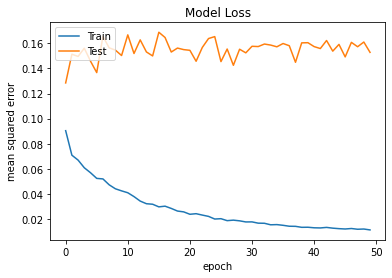

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_2_pred = model_2.predict(X_test)
model_2_pred = scaler.inverse_transform(model_2_pred)

8/8 [==============================] - 2s 33ms/step


In [ ]:
r2_score(y_test, model_2_pred)

-30.79166820179705

77/77 [==============================] - 3s 35ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

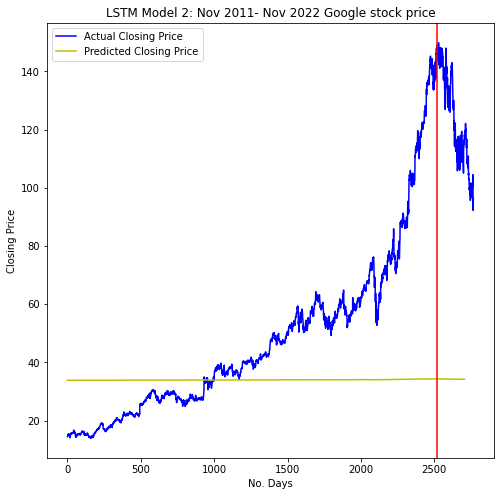

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_2.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_2_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM Model 2: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

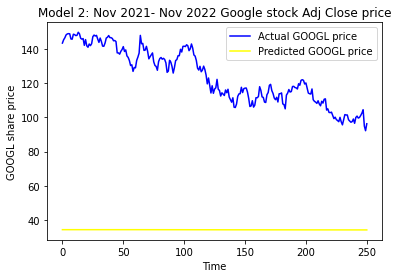

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_2_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Third LSTM - relu, adam

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50, activation = "relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_2.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 17s 194ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 2/50
52/52 [==============================] - 7s 143ms/step - loss: 6.6484e-04 - mean_squared_error: 6.6484e-04 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 3/50
52/52 [==============================] - 7s 143ms/step - loss: 6.1453e-04 - mean_squared_error: 6.1453e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 4/50
52/52 [==============================] - 8s 145ms/step - loss: 6.1306e-04 - mean_squared_error: 6.1306e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 5/50
52/52 [==============================] - 8s 146ms/step - loss: 5.4678e-04 - mean_squared_error: 5.4678e-04 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 6/50
52/52 [==============================] - 8s 146ms/step - loss: 4.8328e-04 - mean_squared_error: 4.8328e-04 - val_loss: 0.0070 - val_mean_squared_e

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


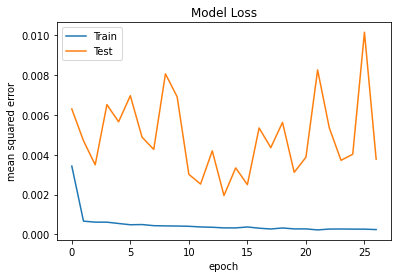

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_2_pred = model_2.predict(X_test)
model_2_pred = scaler.inverse_transform(model_2_pred)

8/8 [==============================] - 2s 37ms/step


In [ ]:
r2_score(y_test, model_2_pred)

-0.8009978088483911

77/77 [==============================] - 3s 34ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

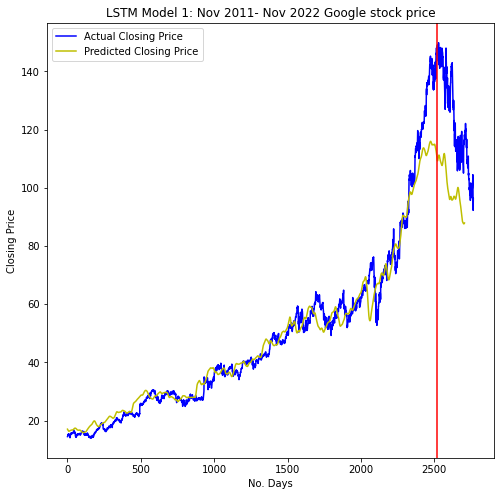

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_2.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_2_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM Model 1: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

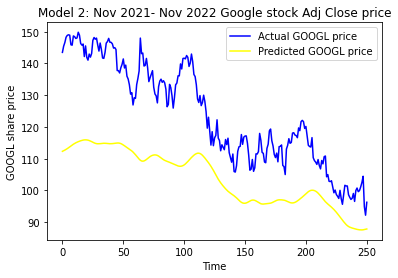

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_2_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Fourth LSTM - relu, sgd

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50, activation = "relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))
model_2.compile(optimizer='SGD', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_2.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 16s 174ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.1688 - val_mean_squared_error: 0.1688
Epoch 2/50
52/52 [==============================] - 7s 141ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.1558 - val_mean_squared_error: 0.1558
Epoch 3/50
52/52 [==============================] - 7s 141ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.1539 - val_mean_squared_error: 0.1539
Epoch 4/50
52/52 [==============================] - 7s 142ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.1527 - val_mean_squared_error: 0.1527
Epoch 5/50
52/52 [==============================] - 7s 142ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.1506 - val_mean_squared_error: 0.1506
Epoch 6/50
52/52 [==============================] - 7s 141ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.1489 - val_mean_squared_error: 0.1489
Epoch 7/50
52/52 [=========

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


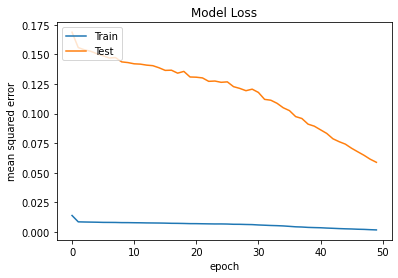

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_2_pred = model_2.predict(X_test)
model_2_pred = scaler.inverse_transform(model_2_pred)

8/8 [==============================] - 2s 34ms/step


In [ ]:
r2_score(y_test, model_2_pred)

-12.454205531137168

77/77 [==============================] - 3s 35ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

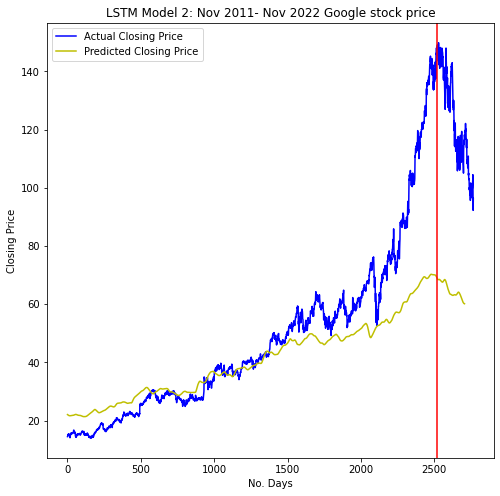

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_2.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_2_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM Model 2: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

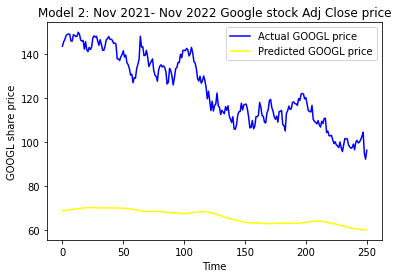

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_2_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Fifth LSTM - tanh, adam

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_2.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 20s 182ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 2/50
52/52 [==============================] - 9s 166ms/step - loss: 4.3473e-04 - mean_squared_error: 4.3473e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 3/50
52/52 [==============================] - 15s 291ms/step - loss: 4.2270e-04 - mean_squared_error: 4.2270e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 4/50
52/52 [==============================] - 13s 249ms/step - loss: 3.4337e-04 - mean_squared_error: 3.4337e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 5/50
52/52 [==============================] - 15s 292ms/step - loss: 3.6489e-04 - mean_squared_error: 3.6489e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 6/50
52/52 [==============================] - 13s 250ms/step - loss: 2.8018e-04 - mean_squared_error: 2.8018e-04 - val_loss: 0.0016 - val_mean_squar

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


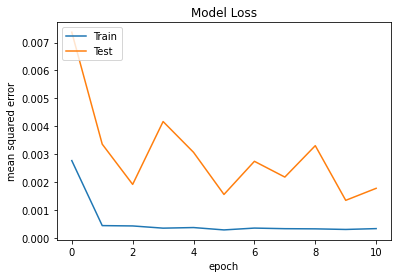

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_2_pred = model_2.predict(X_test)
model_2_pred = scaler.inverse_transform(model_2_pred)

8/8 [==============================] - 3s 33ms/step


In [ ]:
r2_score(y_test, model_2_pred)

0.7772438102786633

77/77 [==============================] - 3s 34ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

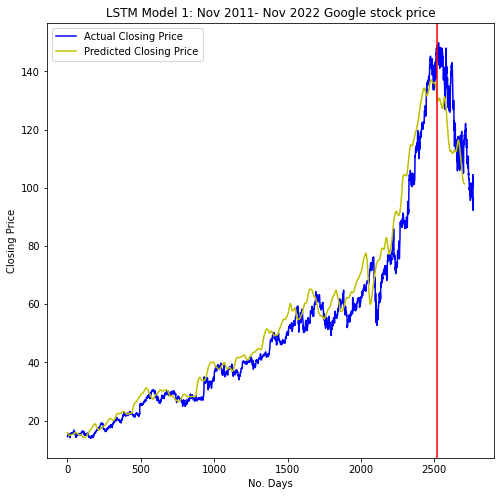

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_2.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_2_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM Model 1: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

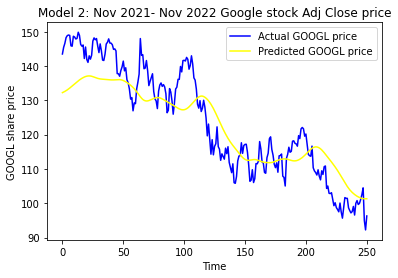

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_2_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Sixth LSTM - tanh, sgd

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))
model_2.compile(optimizer='SGD', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_2.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 17s 192ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.1702 - val_mean_squared_error: 0.1702
Epoch 2/50
52/52 [==============================] - 7s 141ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.1663 - val_mean_squared_error: 0.1663
Epoch 3/50
52/52 [==============================] - 8s 153ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.1613 - val_mean_squared_error: 0.1613
Epoch 4/50
52/52 [==============================] - 7s 140ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.1565 - val_mean_squared_error: 0.1565
Epoch 5/50
52/52 [==============================] - 7s 141ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.1488 - val_mean_squared_error: 0.1488
Epoch 6/50
52/52 [==============================] - 7s 140ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.1524 - val_mean_squared_error: 0.1524
Epoch 7/50
52/52 [=========

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


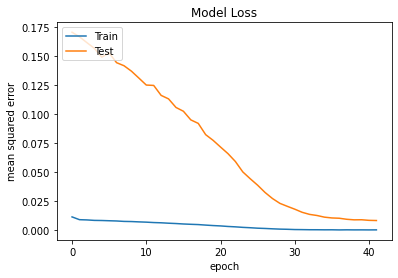

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_2_pred = model_2.predict(X_test)
model_2_pred = scaler.inverse_transform(model_2_pred)

8/8 [==============================] - 2s 34ms/step


In [ ]:
r2_score(y_test, model_2_pred)

-1.1222081194794455

77/77 [==============================] - 3s 35ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

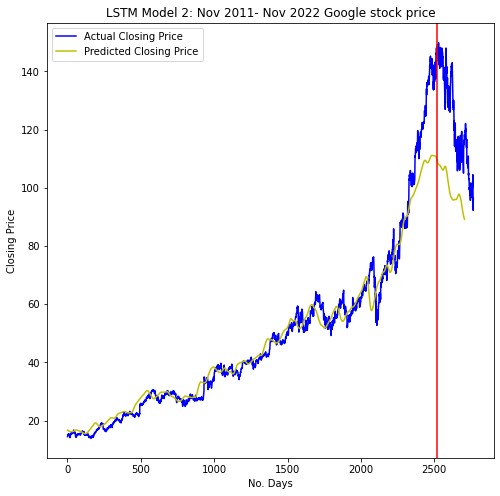

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_2.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_2_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM Model 2: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

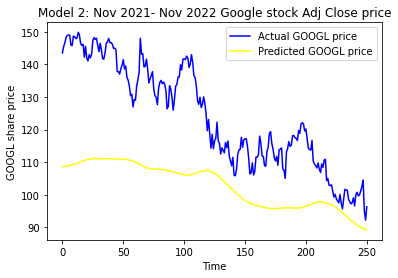

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_2_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

#### Gated Recurrent Unit (GRU) models and experimentation

##### First GRU - Sigmoid, adam

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_3a = Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
model_3a.add(GRU(3, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_3a.add(GRU(3, activation = 'sigmoid', return_sequences=False))
model_3a.add(Dense(1))
model_3a.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_3a.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 9s 106ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.1346 - val_mean_squared_error: 0.1346
Epoch 2/50
52/52 [==============================] - 3s 56ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.1213 - val_mean_squared_error: 0.1213
Epoch 3/50
52/52 [==============================] - 3s 56ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0988 - val_mean_squared_error: 0.0988
Epoch 4/50
52/52 [==============================] - 3s 55ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0735 - val_mean_squared_error: 0.0735
Epoch 5/50
52/52 [==============================] - 3s 55ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0371 - val_mean_squared_error: 0.0371
Epoch 6/50
52/52 [==============================] - 3s 54ms/step - loss: 6.7612e-04 - mean_squared_error: 6.7612e-04 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 7/50
52/52 [=======

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


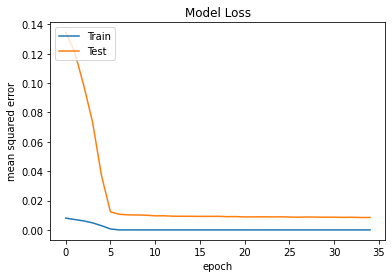

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_3a_pred = model_3a.predict(X_test)
model_3a_pred = scaler.inverse_transform(model_3a_pred)

8/8 [==============================] - 1s 11ms/step


In [ ]:
r2_score(y_test, model_3a_pred)

-1.6173593101247499

77/77 [==============================] - 1s 10ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

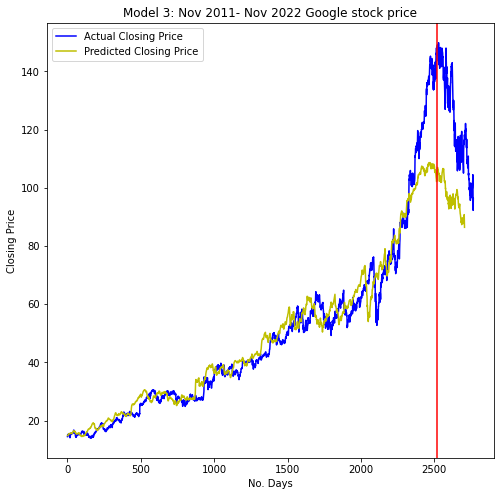

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_3a.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_3a_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"Model 3: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

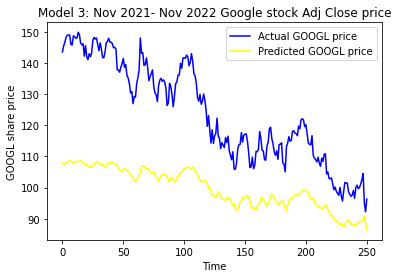

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_3a_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Model 3: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Second GRU - Sigmoid, SGD

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_3b = Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
model_3b.add(GRU(3, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_3b.add(GRU(3, activation = 'sigmoid', return_sequences=False))
model_3b.add(Dense(1))
model_3b.compile(optimizer='SGD', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_3b.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 7s 68ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.1341 - val_mean_squared_error: 0.1341
Epoch 2/50
52/52 [==============================] - 3s 55ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.1442 - val_mean_squared_error: 0.1442
Epoch 3/50
52/52 [==============================] - 3s 54ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.1451 - val_mean_squared_error: 0.1451
Epoch 4/50
52/52 [==============================] - 3s 55ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.1476 - val_mean_squared_error: 0.1476
Epoch 5/50
52/52 [==============================] - 3s 54ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.1459 - val_mean_squared_error: 0.1459
Epoch 6/50
52/52 [==============================] - 3s 55ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.1458 - val_mean_squared_error: 0.1458
Epoch 7/50
52/52 [================

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


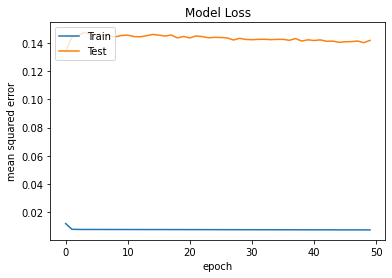

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_3b_pred = model_3b.predict(X_test)
model_3b_pred = scaler.inverse_transform(model_3b_pred)

8/8 [==============================] - 1s 10ms/step


In [ ]:
r2_score(y_test, model_3b_pred)

-28.305323319192972

77/77 [==============================] - 1s 10ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

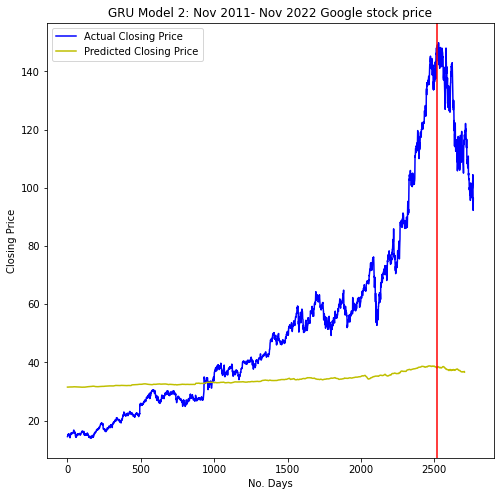

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_3b.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_3b_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"GRU Model 2: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

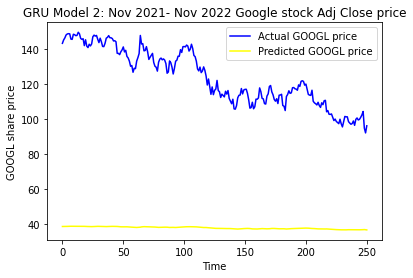

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_3b_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"GRU Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Third GRU - relu, adam

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_3c = Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
model_3c.add(GRU(3, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_3c.add(GRU(3, activation = 'relu', return_sequences=False))
model_3c.add(Dense(1))
model_3c.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_3c.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 7s 68ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.1505 - val_mean_squared_error: 0.1505
Epoch 2/50
52/52 [==============================] - 3s 55ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.1272 - val_mean_squared_error: 0.1272
Epoch 3/50
52/52 [==============================] - 3s 54ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.1021 - val_mean_squared_error: 0.1021
Epoch 4/50
52/52 [==============================] - 3s 56ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0594 - val_mean_squared_error: 0.0594
Epoch 5/50
52/52 [==============================] - 3s 56ms/step - loss: 7.4664e-04 - mean_squared_error: 7.4664e-04 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 6/50
52/52 [==============================] - 3s 56ms/step - loss: 7.3857e-05 - mean_squared_error: 7.3857e-05 - val_loss: 0.0227 - val_mean_squared_error: 0.0227
Epoch 7/50
52/52 [

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


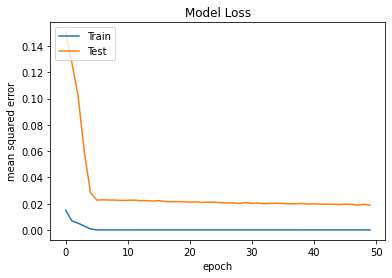

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_3c_pred = model_3c.predict(X_test)
model_3c_pred = scaler.inverse_transform(model_3c_pred)

8/8 [==============================] - 1s 10ms/step


In [ ]:
r2_score(y_test, model_3c_pred)

-4.566024603313595

77/77 [==============================] - 1s 19ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

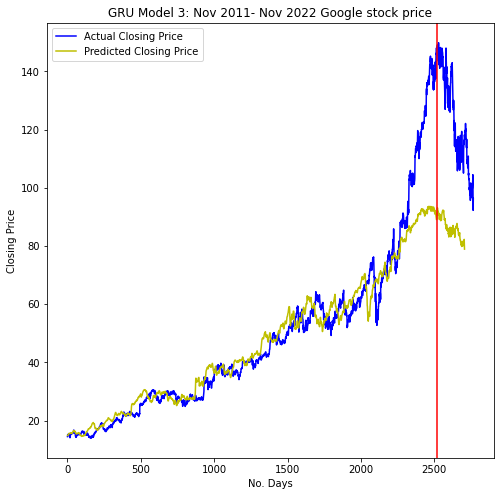

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_3c.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_3c_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"GRU Model 3: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

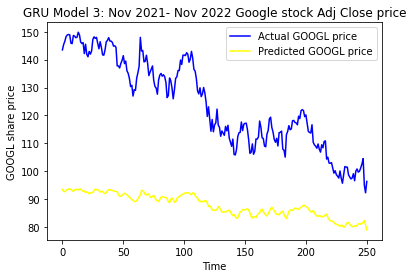

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_3c_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"GRU Model 3: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Fourth GRU - relu, SGD

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_3d = Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
model_3d.add(GRU(3, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_3d.add(GRU(3, activation = 'relu', return_sequences=False))
model_3d.add(Dense(1))
model_3d.compile(optimizer='SGD', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_3d.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 8s 70ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.1571 - val_mean_squared_error: 0.1571
Epoch 2/50
52/52 [==============================] - 3s 55ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.1482 - val_mean_squared_error: 0.1482
Epoch 3/50
52/52 [==============================] - 3s 56ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.1456 - val_mean_squared_error: 0.1456
Epoch 4/50
52/52 [==============================] - 3s 55ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.1458 - val_mean_squared_error: 0.1458
Epoch 5/50
52/52 [==============================] - 3s 55ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.1403 - val_mean_squared_error: 0.1403
Epoch 6/50
52/52 [==============================] - 3s 54ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.1408 - val_mean_squared_error: 0.1408
Epoch 7/50
52/52 [================

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


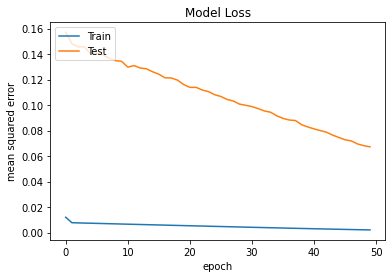

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_3d_pred = model_3d.predict(X_test)
model_3d_pred = scaler.inverse_transform(model_3d_pred)

8/8 [==============================] - 1s 13ms/step


In [ ]:
r2_score(y_test, model_3d_pred)

-14.309077368180628

77/77 [==============================] - 1s 16ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

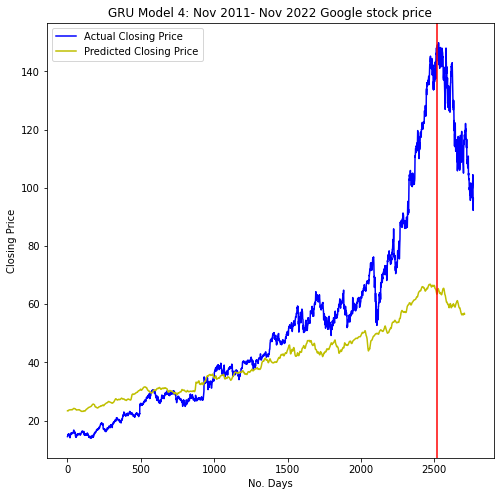

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_3d.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_3d_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"GRU Model 4: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

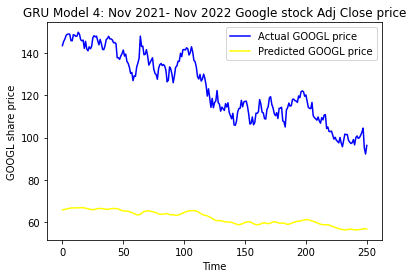

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_3d_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"GRU Model 4: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Fifth GRU - relu, adam

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_3c = Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
model_3c.add(GRU(3, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_3c.add(GRU(3, return_sequences=False))
model_3c.add(Dense(1))
model_3c.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_3c.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 12s 131ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0570 - val_mean_squared_error: 0.0570
Epoch 2/50
52/52 [==============================] - 4s 80ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 3/50
52/52 [==============================] - 4s 77ms/step - loss: 6.0874e-04 - mean_squared_error: 6.0874e-04 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 4/50
52/52 [==============================] - 3s 57ms/step - loss: 1.0472e-04 - mean_squared_error: 1.0472e-04 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 5/50
52/52 [==============================] - 3s 56ms/step - loss: 3.2389e-05 - mean_squared_error: 3.2389e-05 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 6/50
52/52 [==============================] - 3s 57ms/step - loss: 3.0031e-05 - mean_squared_error: 3.0031e-05 - val_loss: 0.0046 - val_mean_squared_error: 0.0046


dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


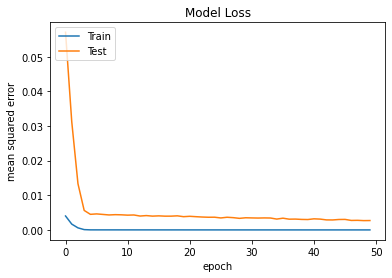

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_3c_pred = model_3c.predict(X_test)
model_3c_pred = scaler.inverse_transform(model_3c_pred)

8/8 [==============================] - 1s 10ms/step


In [ ]:
r2_score(y_test, model_3c_pred)

0.1881718259824865

77/77 [==============================] - 1s 13ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

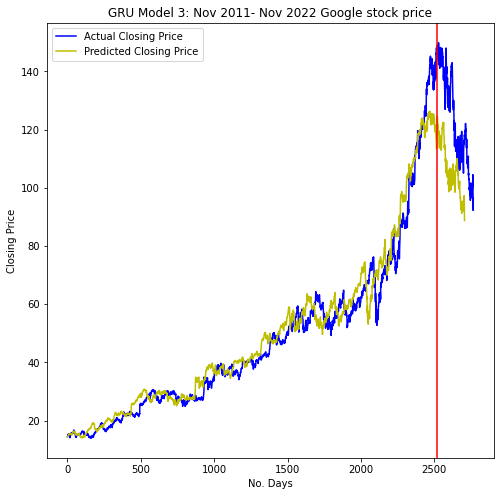

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_3c.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_3c_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"GRU Model 3: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

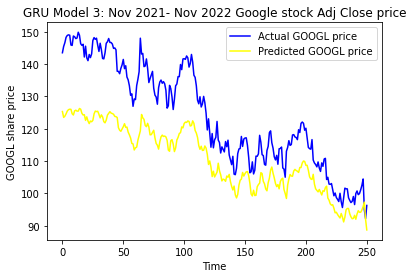

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_3c_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"GRU Model 3: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Sixth GRU - tanh, SGD

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_3d = Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
model_3d.add(GRU(3, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_3d.add(GRU(3, return_sequences=False))
model_3d.add(Dense(1))
model_3d.compile(optimizer='SGD', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_3d.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 9s 78ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.1674 - val_mean_squared_error: 0.1674
Epoch 2/50
52/52 [==============================] - 3s 57ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.1606 - val_mean_squared_error: 0.1606
Epoch 3/50
52/52 [==============================] - 3s 61ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.1562 - val_mean_squared_error: 0.1562
Epoch 4/50
52/52 [==============================] - 3s 59ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.1483 - val_mean_squared_error: 0.1483
Epoch 5/50
52/52 [==============================] - 3s 59ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.1431 - val_mean_squared_error: 0.1431
Epoch 6/50
52/52 [==============================] - 3s 59ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.1365 - val_mean_squared_error: 0.1365
Epoch 7/50
52/52 [================

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


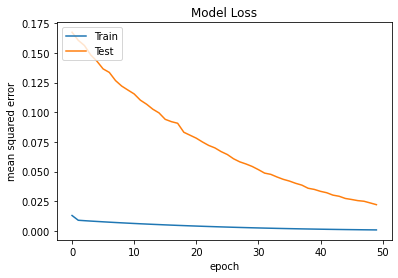

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_3d_pred = model_3d.predict(X_test)
model_3d_pred = scaler.inverse_transform(model_3d_pred)

8/8 [==============================] - 1s 10ms/step


In [ ]:
r2_score(y_test, model_3d_pred)

-4.045803143487861

77/77 [==============================] - 1s 10ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

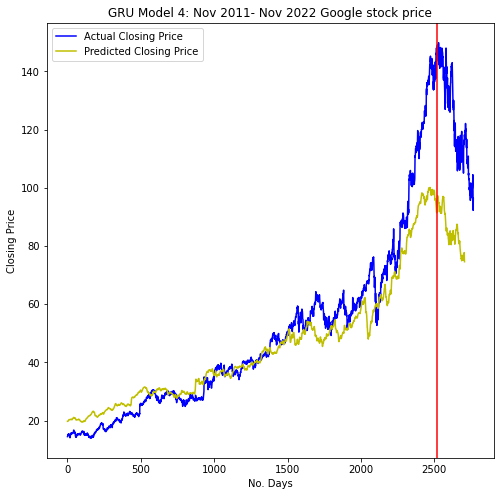

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_3d.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_3d_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"GRU Model 4: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

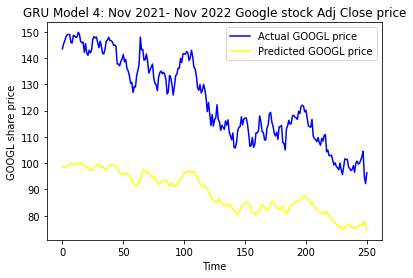

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_3d_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"GRU Model 4: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

### Section 2: Standard Scaler

In [ ]:
# first round of tests will use minmax scaler
# fit and transform training dataset
scaler =  StandardScaler()
scaled_df = scaler.fit_transform(train_df['Adj Close'].values.reshape(-1,1))

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
# fit and transform test dataset
#sc =  StandardScaler()
#scaled_test_df = sc.fit_transform(test_df['Adj Close'].values.reshape(-1,1))
#scaled_test_df = sc.transform(scaled_test_df)

In [ ]:
# Concatenate training and test datasets to create a total dataset
# which will shape the inputs and thus 

total_df = pd.concat((train_df['Adj Close'], test_df['Adj Close']), axis=0) 
inputs = total_df[len(train_df) - len(total_df) - days:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [ ]:
X_test = []
for i in range(days, len(inputs)):
  X_test.append(inputs[i-days:i,0])

In [ ]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [ ]:
y_test = test_df['Adj Close'].values
real_prices = test_df['Adj Close'].values

#### Long Short-Term Memory (LSTM) models and experimentation

##### First LSTM - Sigmoid, adam

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50, activation = "sigmoid"))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_2.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 15s 153ms/step - loss: 0.1106 - mean_squared_error: 0.1106 - val_loss: 1.4129 - val_mean_squared_error: 1.4129
Epoch 2/50
52/52 [==============================] - 7s 128ms/step - loss: 0.0395 - mean_squared_error: 0.0395 - val_loss: 1.2428 - val_mean_squared_error: 1.2428
Epoch 3/50
52/52 [==============================] - 7s 129ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 1.1577 - val_mean_squared_error: 1.1577
Epoch 4/50
52/52 [==============================] - 7s 128ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 1.1174 - val_mean_squared_error: 1.1174
Epoch 5/50
52/52 [==============================] - 7s 127ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 1.1193 - val_mean_squared_error: 1.1193
Epoch 6/50
52/52 [==============================] - 7s 127ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.9570 - val_mean_squared_error: 0.9570
Epoch 7/50
52/52 [=========

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


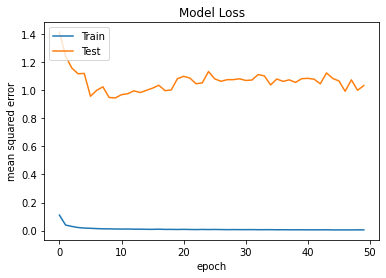

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_2_pred = model_2.predict(X_test)
model_2_pred = scaler.inverse_transform(model_2_pred)

8/8 [==============================] - 2s 33ms/step


In [ ]:
r2_score(y_test, model_2_pred)

-12.613238400334822

77/77 [==============================] - 2s 31ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

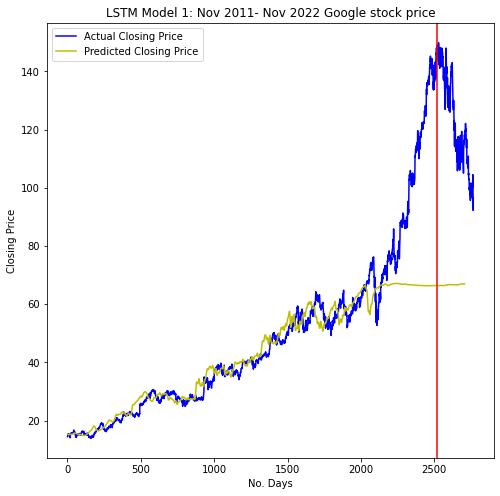

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_2.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_2_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM Model 1: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

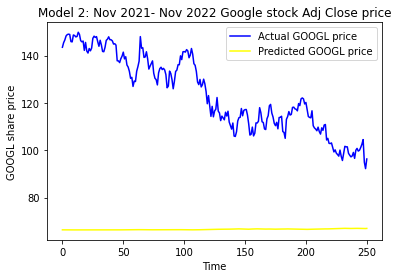

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_2_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Second LSTM - Sigmoid, SGD

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50, activation = "sigmoid"))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))
model_2.compile(optimizer='SGD', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_2.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 15s 158ms/step - loss: 0.2482 - mean_squared_error: 0.2482 - val_loss: 3.5023 - val_mean_squared_error: 3.5023
Epoch 2/50
52/52 [==============================] - 7s 128ms/step - loss: 0.2446 - mean_squared_error: 0.2446 - val_loss: 3.5200 - val_mean_squared_error: 3.5200
Epoch 3/50
52/52 [==============================] - 7s 129ms/step - loss: 0.2404 - mean_squared_error: 0.2404 - val_loss: 3.2752 - val_mean_squared_error: 3.2752
Epoch 4/50
52/52 [==============================] - 7s 129ms/step - loss: 0.2360 - mean_squared_error: 0.2360 - val_loss: 3.4269 - val_mean_squared_error: 3.4269
Epoch 5/50
52/52 [==============================] - 7s 128ms/step - loss: 0.2255 - mean_squared_error: 0.2255 - val_loss: 3.3029 - val_mean_squared_error: 3.3029
Epoch 6/50
52/52 [==============================] - 7s 129ms/step - loss: 0.2144 - mean_squared_error: 0.2144 - val_loss: 3.2647 - val_mean_squared_error: 3.2647
Epoch 7/50
52/52 [=========

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


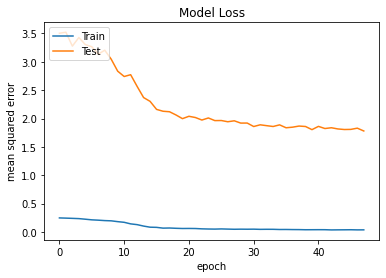

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_2_pred = model_2.predict(X_test)
model_2_pred = scaler.inverse_transform(model_2_pred)

8/8 [==============================] - 2s 33ms/step


In [ ]:
r2_score(y_test, model_2_pred)

-20.03587201422647

77/77 [==============================] - 2s 31ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

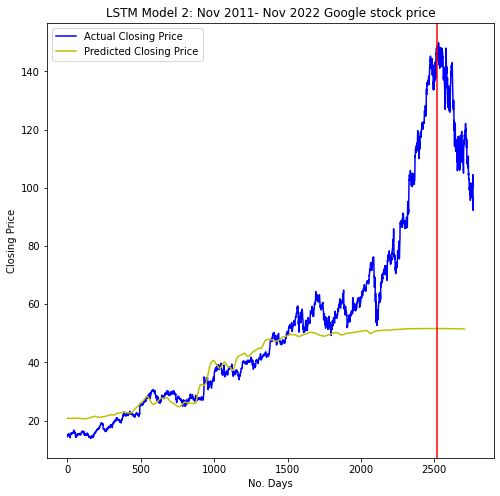

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_2.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_2_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM Model 2: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

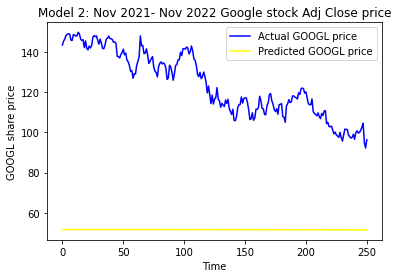

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_2_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Third LSTM - relu, adam

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50, activation = "relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_2.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 16s 179ms/step - loss: 0.0702 - mean_squared_error: 0.0702 - val_loss: 0.9709 - val_mean_squared_error: 0.9709
Epoch 2/50
52/52 [==============================] - 7s 128ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.5771 - val_mean_squared_error: 0.5771
Epoch 3/50
52/52 [==============================] - 7s 128ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.4253 - val_mean_squared_error: 0.4253
Epoch 4/50
52/52 [==============================] - 7s 127ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.2646 - val_mean_squared_error: 0.2646
Epoch 5/50
52/52 [==============================] - 7s 128ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.4452 - val_mean_squared_error: 0.4452
Epoch 6/50
52/52 [==============================] - 7s 128ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.5725 - val_mean_squared_error: 0.5725
Epoch 7/50
52/52 [=========

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


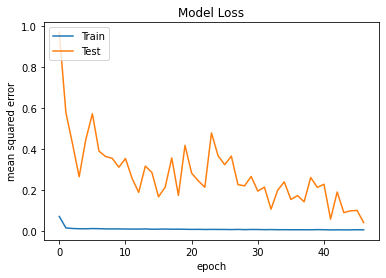

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_2_pred = model_2.predict(X_test)
model_2_pred = scaler.inverse_transform(model_2_pred)

8/8 [==============================] - 2s 31ms/step


In [ ]:
r2_score(y_test, model_2_pred)

0.3704344514348211

77/77 [==============================] - 2s 30ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

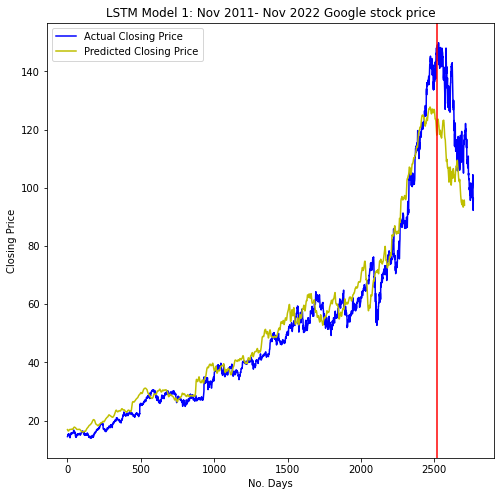

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_2.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_2_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM Model 1: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

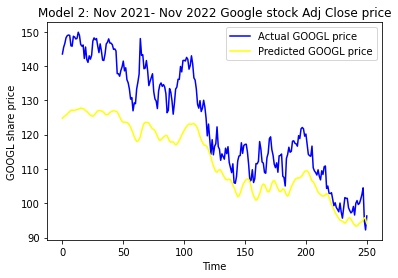

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_2_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Fourth LSTM - relu, sgd

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50, activation = "relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))
model_2.compile(optimizer='SGD', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_2.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 15s 166ms/step - loss: 0.1982 - mean_squared_error: 0.1982 - val_loss: 2.5571 - val_mean_squared_error: 2.5571
Epoch 2/50
52/52 [==============================] - 7s 128ms/step - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 2.2569 - val_mean_squared_error: 2.2569
Epoch 3/50
52/52 [==============================] - 7s 128ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 2.0012 - val_mean_squared_error: 2.0012
Epoch 4/50
52/52 [==============================] - 7s 126ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 1.8320 - val_mean_squared_error: 1.8320
Epoch 5/50
52/52 [==============================] - 7s 128ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 1.7254 - val_mean_squared_error: 1.7254
Epoch 6/50
52/52 [==============================] - 7s 127ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 1.6538 - val_mean_squared_error: 1.6538
Epoch 7/50
52/52 [=========

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


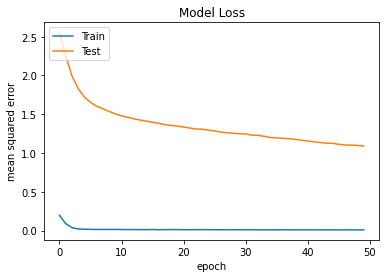

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_2_pred = model_2.predict(X_test)
model_2_pred = scaler.inverse_transform(model_2_pred)

8/8 [==============================] - 2s 30ms/step


In [ ]:
r2_score(y_test, model_2_pred)

-12.484697576469825

77/77 [==============================] - 2s 30ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

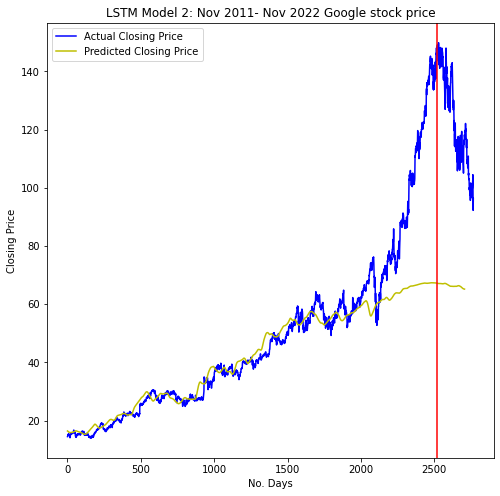

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_2.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_2_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM Model 2: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

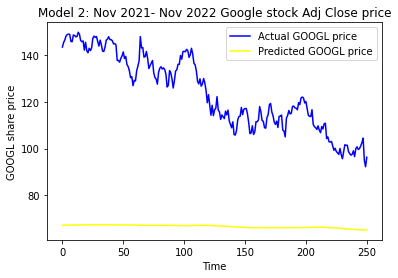

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_2_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Fifth LSTM - tanh, adam

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_2.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 15s 157ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.8566 - val_mean_squared_error: 0.8566
Epoch 2/50
52/52 [==============================] - 7s 125ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.6374 - val_mean_squared_error: 0.6374
Epoch 3/50
52/52 [==============================] - 6s 125ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.5400 - val_mean_squared_error: 0.5400
Epoch 4/50
52/52 [==============================] - 6s 125ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.4837 - val_mean_squared_error: 0.4837
Epoch 5/50
52/52 [==============================] - 7s 126ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.4080 - val_mean_squared_error: 0.4080
Epoch 6/50
52/52 [==============================] - 7s 126ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.3462 - val_mean_squared_error: 0.3462
Epoch 7/50
52/52 [=========

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


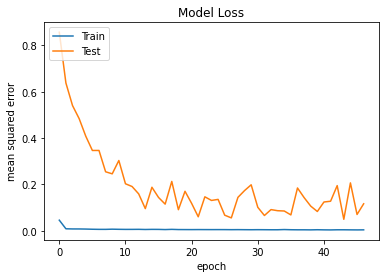

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_2_pred = model_2.predict(X_test)
model_2_pred = scaler.inverse_transform(model_2_pred)

8/8 [==============================] - 3s 30ms/step


In [ ]:
r2_score(y_test, model_2_pred)

-0.5182652385904116

77/77 [==============================] - 2s 30ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

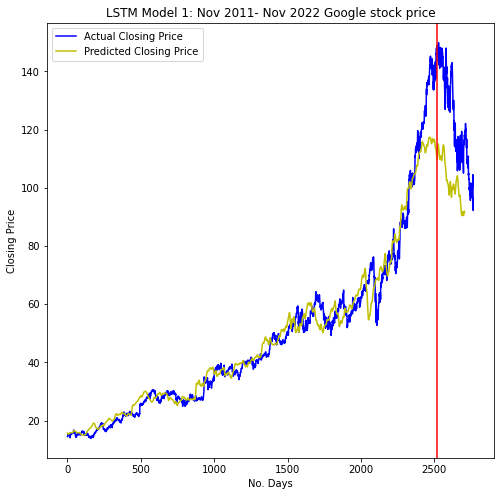

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_2.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_2_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM Model 1: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

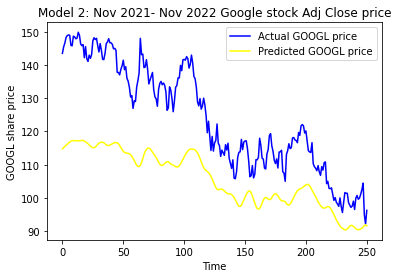

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_2_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### Sixth LSTM - tanh, sgd

In [ ]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))
model_2.compile(optimizer='SGD', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_2.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=32, callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 15s 161ms/step - loss: 0.1669 - mean_squared_error: 0.1669 - val_loss: 1.9358 - val_mean_squared_error: 1.9358
Epoch 2/50
52/52 [==============================] - 7s 129ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.9940 - val_mean_squared_error: 0.9940
Epoch 3/50
52/52 [==============================] - 8s 151ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.8867 - val_mean_squared_error: 0.8867
Epoch 4/50
52/52 [==============================] - 7s 127ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.8794 - val_mean_squared_error: 0.8794
Epoch 5/50
52/52 [==============================] - 7s 127ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.8908 - val_mean_squared_error: 0.8908
Epoch 6/50
52/52 [==============================] - 7s 127ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.9029 - val_mean_squared_error: 0.9029
Epoch 7/50
52/52 [=========

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


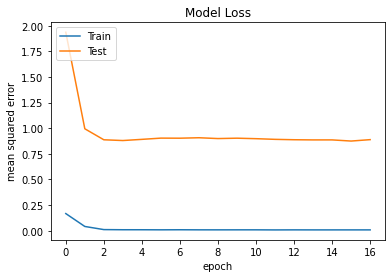

In [ ]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_2_pred = model_2.predict(X_test)
model_2_pred = scaler.inverse_transform(model_2_pred)

8/8 [==============================] - 2s 31ms/step


In [ ]:
r2_score(y_test, model_2_pred)

-10.446882664431646

77/77 [==============================] - 2s 31ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

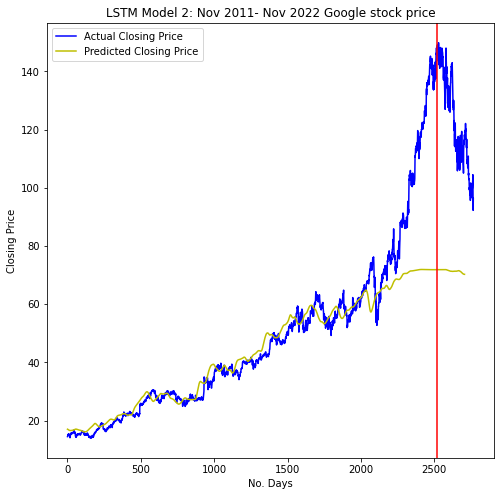

In [ ]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_2.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_2_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM Model 2: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

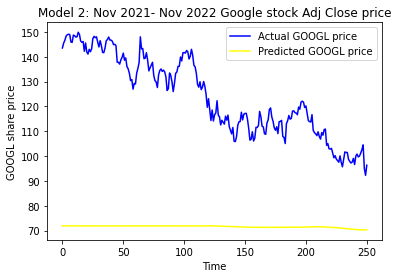

In [ ]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_2_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

## Phase 3: Final testing

##### LSTM one - tanh, adam, min-max

In [126]:
# first round of tests will use minmax scaler
# fit and transform training dataset
scaler =  MinMaxScaler()
scaled_df = scaler.fit_transform(train_df['Adj Close'].values.reshape(-1,1))

In [127]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [128]:
# fit and transform test dataset
#sc =  StandardScaler()
#scaled_test_df = sc.fit_transform(test_df['Adj Close'].values.reshape(-1,1))
#scaled_test_df = sc.transform(scaled_test_df)

In [129]:
# Concatenate training and test datasets to create a total dataset
# which will shape the inputs and thus 

total_df = pd.concat((train_df['Adj Close'], test_df['Adj Close']), axis=0) 
inputs = total_df[len(train_df) - len(total_df) - days:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [130]:
X_test = []
for i in range(days, len(inputs)):
  X_test.append(inputs[i-days:i,0])

In [131]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [132]:
y_test = test_df['Adj Close'].values
real_prices = test_df['Adj Close'].values

In [133]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [134]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=200, batch_size=32, callbacks = [callback])

Epoch 1/200
77/77 [==============================] - 18s 133ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 2/200
77/77 [==============================] - 10s 131ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 3/200
77/77 [==============================] - 10s 136ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 4/200
77/77 [==============================] - 10s 127ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 5/200
77/77 [==============================] - 10s 132ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 6/200
77/77 [==============================] - 11s 146ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 7/200
77/77 [==============================] - 10s 135ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 8/200
77/77 [==============================] - 10s 131ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 9/200
77/77 [==============================] - 10s 126ms/step - loss: 0.0011 - mean_squared_error:

dict_keys(['loss', 'mean_squared_error'])


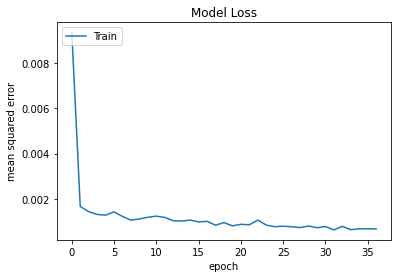

In [135]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [136]:
model_pred = model.predict(X_test)
model_pred = scaler.inverse_transform(model_pred)

8/8 [==============================] - 3s 39ms/step


In [137]:
r2_score(y_test, model_pred)

0.8454075145899256

77/77 [==============================] - 3s 34ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

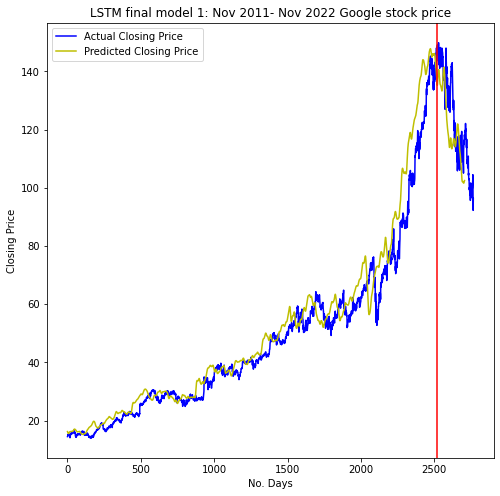

In [138]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM final model 1: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

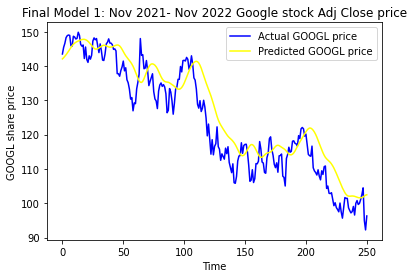

In [139]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Final Model 1: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()

##### LSTM two - relu, adam, standard

In [140]:
# first round of tests will use minmax scaler
# fit and transform training dataset
scaler =  StandardScaler()
scaled_df = scaler.fit_transform(train_df['Adj Close'].values.reshape(-1,1))

In [141]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [142]:
# fit and transform test dataset
#sc =  StandardScaler()
#scaled_test_df = sc.fit_transform(test_df['Adj Close'].values.reshape(-1,1))
#scaled_test_df = sc.transform(scaled_test_df)

In [143]:
# Concatenate training and test datasets to create a total dataset
# which will shape the inputs and thus 

total_df = pd.concat((train_df['Adj Close'], test_df['Adj Close']), axis=0) 
inputs = total_df[len(train_df) - len(total_df) - days:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [144]:
X_test = []
for i in range(days, len(inputs)):
  X_test.append(inputs[i-days:i,0])

In [145]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [146]:
y_test = test_df['Adj Close'].values
real_prices = test_df['Adj Close'].values

In [147]:
# create X and Y training sets with 60-day time series

days = 60
X_train = []
y_train = []
for i  in range(days, len(scaled_df)):
  X_train.append(scaled_df[i-days:i,0])
  y_train.append(scaled_df[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [148]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50, activation = "relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)
history = model_2.fit(X_train, y_train, epochs=200, batch_size=32, callbacks = [callback])

Epoch 1/200
77/77 [==============================] - 19s 139ms/step - loss: 0.1416 - mean_squared_error: 0.1416
Epoch 2/200
77/77 [==============================] - 10s 129ms/step - loss: 0.0402 - mean_squared_error: 0.0402
Epoch 3/200
77/77 [==============================] - 10s 130ms/step - loss: 0.0369 - mean_squared_error: 0.0369
Epoch 4/200
77/77 [==============================] - 11s 146ms/step - loss: 0.0349 - mean_squared_error: 0.0349
Epoch 5/200
77/77 [==============================] - 11s 137ms/step - loss: 0.0298 - mean_squared_error: 0.0298
Epoch 6/200
77/77 [==============================] - 10s 135ms/step - loss: 0.0403 - mean_squared_error: 0.0403
Epoch 7/200
77/77 [==============================] - 10s 134ms/step - loss: 0.0304 - mean_squared_error: 0.0304
Epoch 8/200
77/77 [==============================] - 10s 124ms/step - loss: 0.0283 - mean_squared_error: 0.0283
Epoch 9/200
77/77 [==============================] - 10s 133ms/step - loss: 0.0247 - mean_squared_error:

dict_keys(['loss', 'mean_squared_error'])


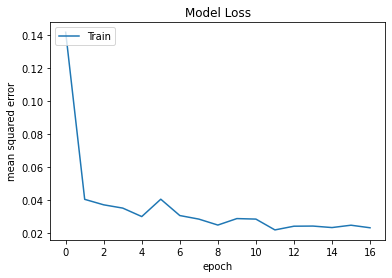

In [149]:
print(history.history.keys())
#plot mean squared error from history
plt.plot(history.history['mean_squared_error'])
plt.title('Model Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [150]:
model_2_pred = model_2.predict(X_test)
model_2_pred = scaler.inverse_transform(model_2_pred)

8/8 [==============================] - 2s 36ms/step


In [151]:
r2_score(y_test, model_2_pred)

0.866161865146202

77/77 [==============================] - 3s 33ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses

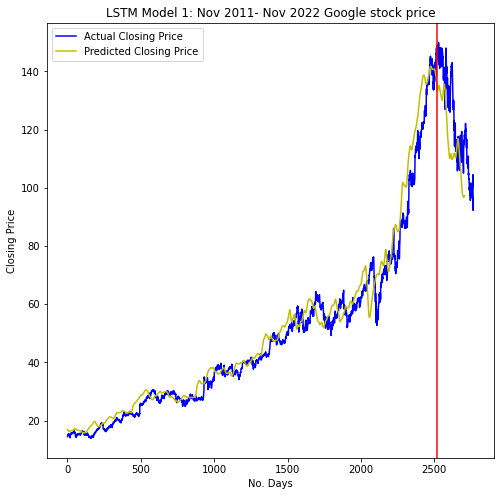

In [152]:
y_test = test_df['Adj Close'].values
y_train = train_df['Adj Close'].values
train_pred = model_2.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
total_data_predicted = np.vstack([train_pred, model_2_pred])
y_close = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(8,8))

plt.title(f"LSTM Model 1: Nov 2011- Nov 2022 Google stock price")
plt.plot(y_close, color='b', label='Actual Closing Price')
plt.plot(total_data_predicted.ravel(),color='y', label='Predicted Closing Price')
plt.axvline(x = 2516, color = 'r', linestyle = '-')
fig.add_subplot(111).set_xlabel('No. Days')
fig.add_subplot(111).set_ylabel('Closing Price')
fig.add_subplot(111).legend(loc='best')
plt.show()

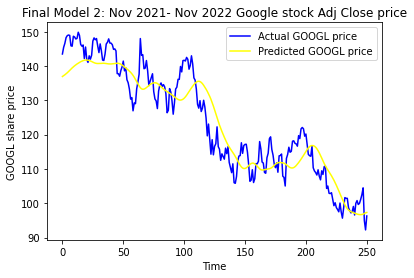

In [153]:
plt.plot(real_prices, color='blue', label = f"Actual {stock} price")
plt.plot(model_2_pred, color='yellow', label=f"Predicted {stock} price")
plt.title(f"Final Model 2: Nov 2021- Nov 2022 Google stock Adj Close price")
plt.xlabel("Time")
plt.ylabel(f"{stock} share price")
plt.legend()
plt.show()